# TAXI FARE PREDICTION

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
# Load the original dataset (replace 'your_dataset.csv' with your actual file path)
### df = pd.read_csv('yellow_tripdata_2024-01.csv')

# Select the first 200,000 rows from the dataset
### df_subset = df.head(200000)  # Alternatively, you can use df.sample(200000) for random rows

# Save the selected rows to a new CSV file
### df_subset.to_csv('200k_rows.csv', index=False)

#### print("200,000 rows have been saved to 'subset_200k_rows.csv'")


In [3]:
df = pd.read_csv('100k_rows.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               100000 non-null  int64  
 1   tpep_pickup_datetime   100000 non-null  object 
 2   tpep_dropoff_datetime  100000 non-null  object 
 3   passenger_count        100000 non-null  int64  
 4   trip_distance          100000 non-null  float64
 5   RatecodeID             100000 non-null  int64  
 6   store_and_fwd_flag     100000 non-null  object 
 7   PULocationID           100000 non-null  int64  
 8   DOLocationID           100000 non-null  int64  
 9   payment_type           100000 non-null  int64  
 10  fare_amount            100000 non-null  float64
 11  extra                  100000 non-null  float64
 12  mta_tax                100000 non-null  float64
 13  tip_amount             100000 non-null  float64
 14  tolls_amount           100000 non-nul

In [11]:
print(df.isnull().sum())

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
Airport_fee              0
dtype: int64


In [13]:
# Convert date columns to datetime
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Convert passenger_count, RatecodeID, congestion_surcharge, and Airport_fee to numeric
df['passenger_count'] = pd.to_numeric(df['passenger_count'], errors='coerce')
df['RatecodeID'] = pd.to_numeric(df['RatecodeID'], errors='coerce')
df['congestion_surcharge'] = pd.to_numeric(df['congestion_surcharge'], errors='coerce')
df['Airport_fee'] = pd.to_numeric(df['Airport_fee'], errors='coerce')


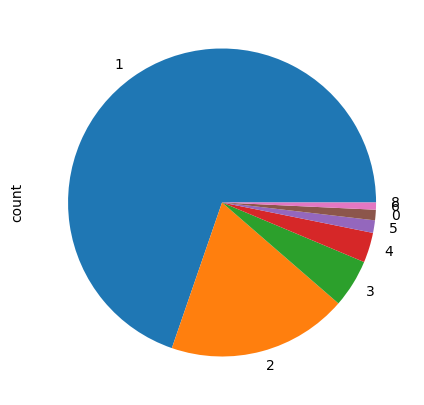

In [15]:
plot = df["passenger_count"].value_counts().plot(kind='pie', y=df["passenger_count"].value_counts().values, figsize=(10, 5))

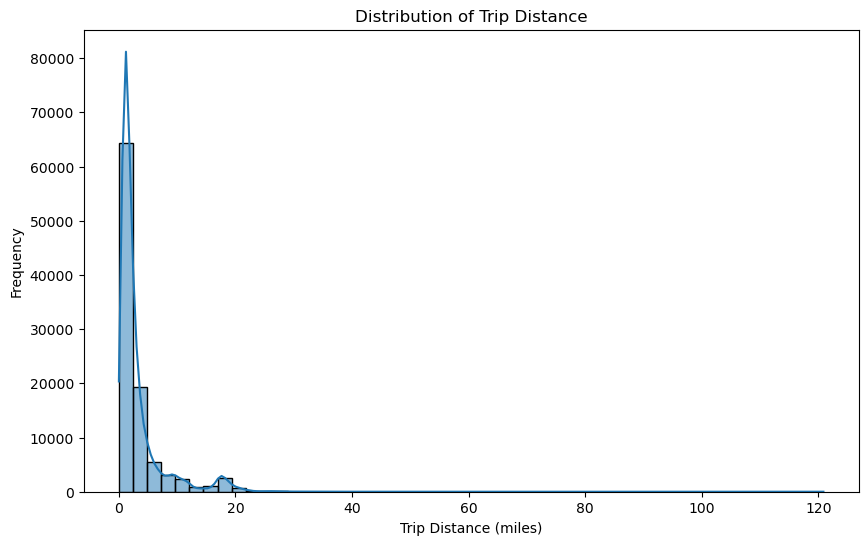

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df['trip_distance'], bins=50, kde=True)
plt.title('Distribution of Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.show()

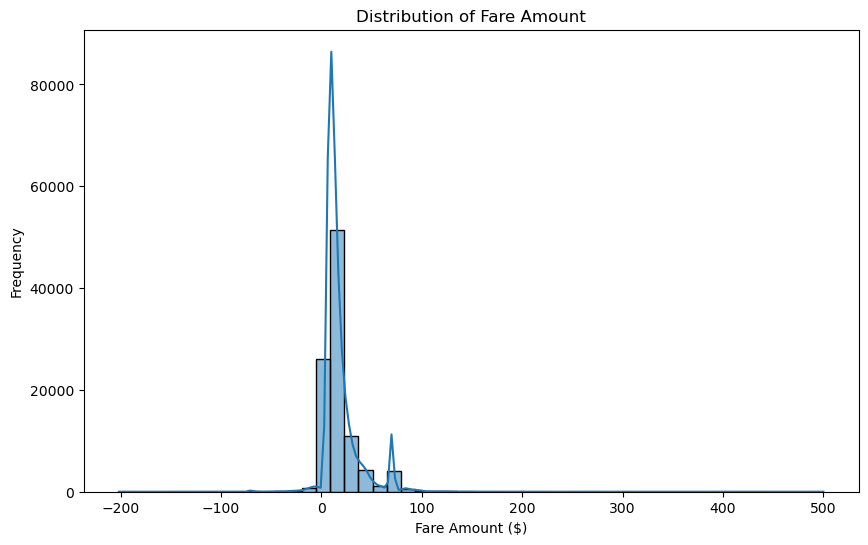

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

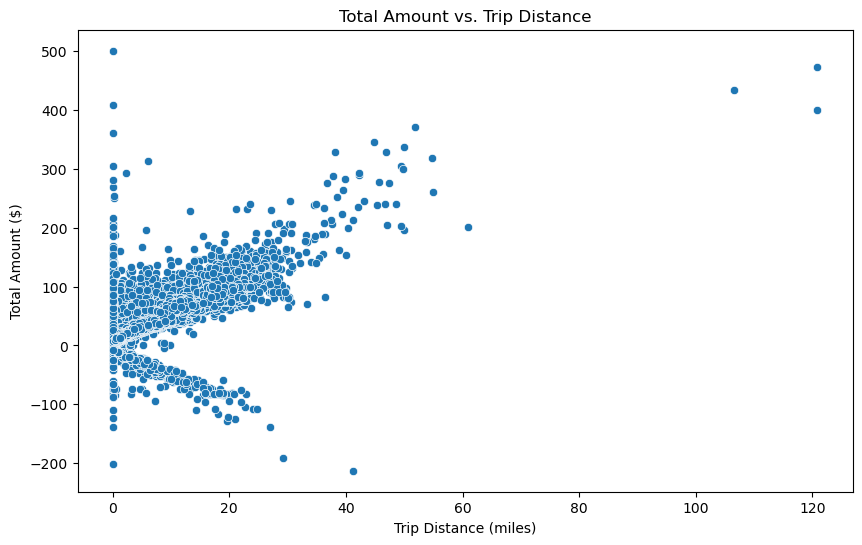

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='total_amount', data=df)
plt.title('Total Amount vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Total Amount ($)')
plt.show()

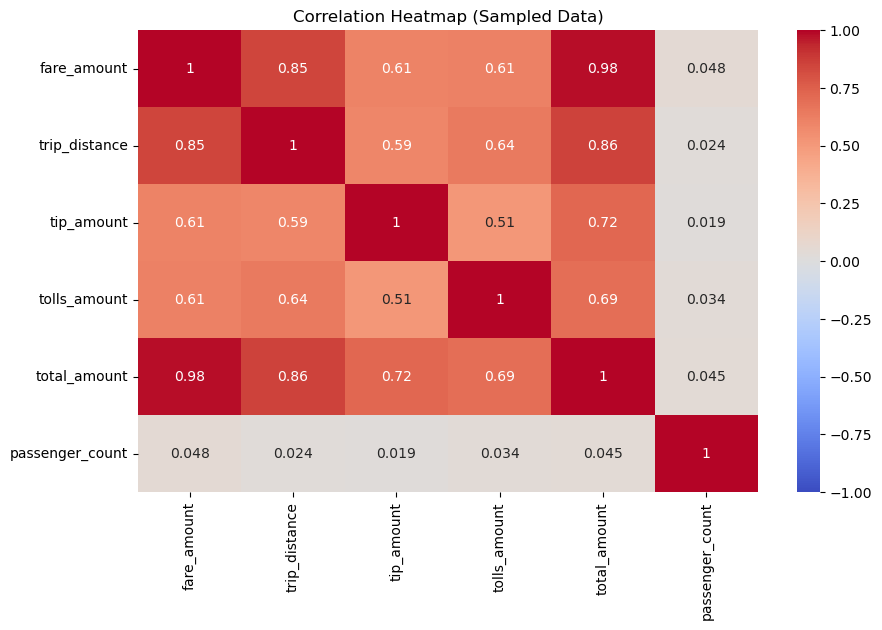

In [26]:
# Take a random sample of 10,000 rows from the DataFrame for faster computation
df_sample = df.sample(n=10000, random_state=42)

plt.figure(figsize=(10, 6))
corr = df_sample[['fare_amount', 'trip_distance', 'tip_amount', 'tolls_amount', 'total_amount', 'passenger_count']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Sampled Data)')
plt.show()


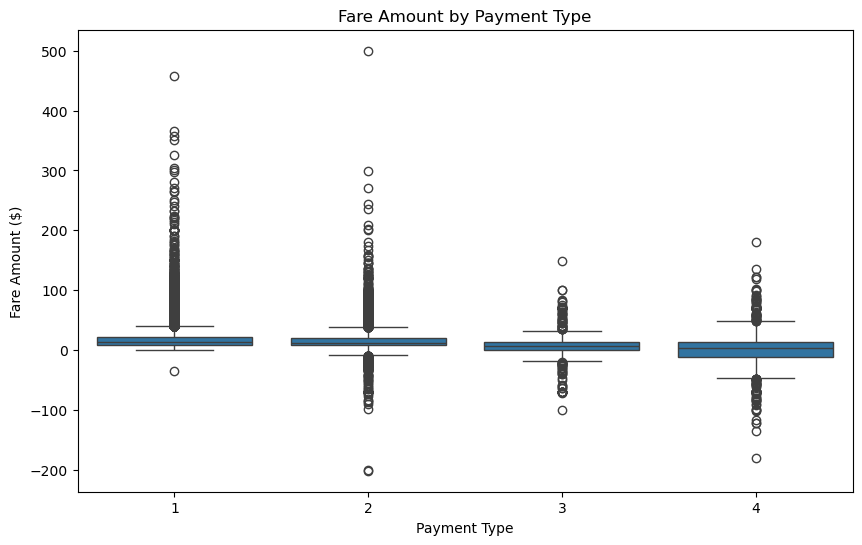

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='payment_type', y='fare_amount', data=df)
plt.title('Fare Amount by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Fare Amount ($)')
plt.show()

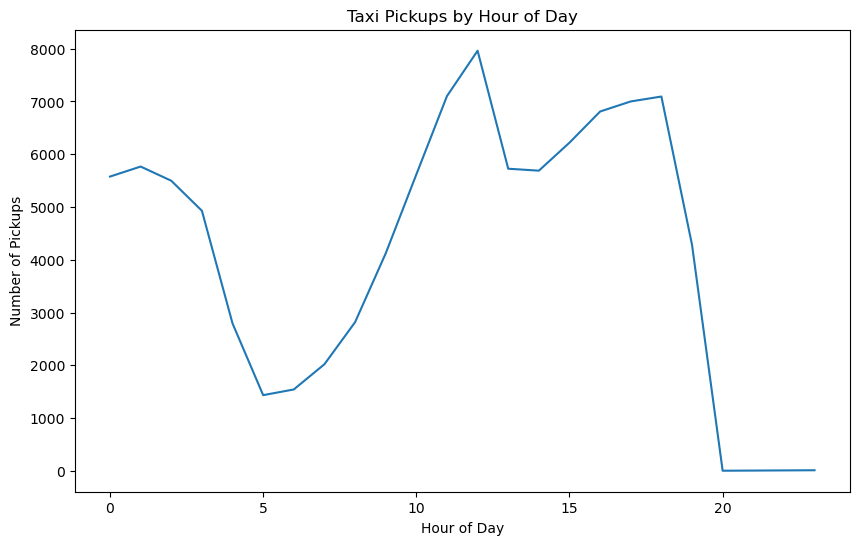

In [30]:
#Analyzing taxi pickups over time gives an understanding of demand patterns.

df.set_index('tpep_pickup_datetime', inplace=True)
df['pickup_hour'] = df.index.hour

plt.figure(figsize=(10, 6))
df.groupby('pickup_hour').size().plot(kind='line')
plt.title('Taxi Pickups by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.show()

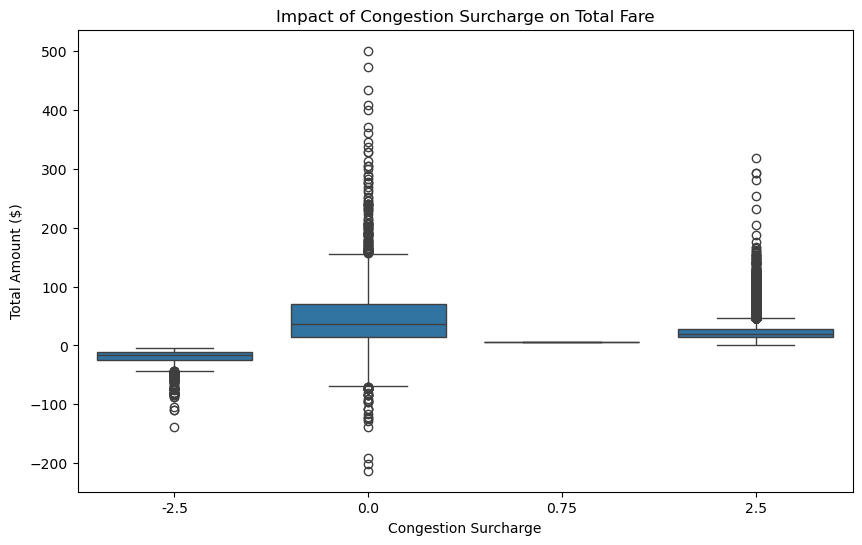

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='congestion_surcharge', y='total_amount', data=df)
plt.title('Impact of Congestion Surcharge on Total Fare')
plt.xlabel('Congestion Surcharge')
plt.ylabel('Total Amount ($)')
plt.show()

In [34]:
# IQR


def calculate_iqr(df):
    numeric_columns = df.select_dtypes(include=[int, float])
    for col in numeric_columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lf = q1 - 1.5 * iqr
        uf = q3 + 1.5 * iqr
        print(f"Column: {col}, Lower bound: {lf}, Upper bound: {uf}")
calculate_iqr(df)

Column: VendorID, Lower bound: 2.0, Upper bound: 2.0
Column: passenger_count, Lower bound: -0.5, Upper bound: 3.5
Column: trip_distance, Lower bound: -2.4299999999999997, Upper bound: 6.77
Column: RatecodeID, Lower bound: 1.0, Upper bound: 1.0
Column: PULocationID, Lower bound: -38.5, Upper bound: 397.5
Column: DOLocationID, Lower bound: -83.5, Upper bound: 424.5
Column: payment_type, Lower bound: 1.0, Upper bound: 1.0
Column: fare_amount, Lower bound: -9.250000000000002, Upper bound: 38.35
Column: extra, Lower bound: -1.5, Upper bound: 2.5
Column: mta_tax, Lower bound: 0.5, Upper bound: 0.5
Column: tip_amount, Lower bound: -3.85, Upper bound: 9.030000000000001
Column: tolls_amount, Lower bound: 0.0, Upper bound: 0.0
Column: improvement_surcharge, Lower bound: 1.0, Upper bound: 1.0
Column: total_amount, Lower bound: -6.57, Upper bound: 50.15
Column: congestion_surcharge, Lower bound: 2.5, Upper bound: 2.5
Column: Airport_fee, Lower bound: 0.0, Upper bound: 0.0
Column: pickup_hour, Lowe

In [36]:
# Capping the columns based on the given lower and upper bounds
df["VendorID"] = np.where(df["VendorID"] > 2.0, 2.0, np.where(df["VendorID"] < 2.0, 2.0, df["VendorID"]))

df["passenger_count"] = np.where(df["passenger_count"] > 3.5, 3.5, 
                                 np.where(df["passenger_count"] < -0.5, -0.5, df["passenger_count"]))

df["trip_distance"] = np.where(df["trip_distance"] > 6.77, 6.77, 
                               np.where(df["trip_distance"] < -2.43, -2.43, df["trip_distance"]))

df["RatecodeID"] = np.where(df["RatecodeID"] > 1.0, 1.0, 
                            np.where(df["RatecodeID"] < 1.0, 1.0, df["RatecodeID"]))

df["PULocationID"] = np.where(df["PULocationID"] > 397.5, 397.5, 
                              np.where(df["PULocationID"] < -38.5, -38.5, df["PULocationID"]))

df["DOLocationID"] = np.where(df["DOLocationID"] > 424.5, 424.5, 
                              np.where(df["DOLocationID"] < -83.5, -83.5, df["DOLocationID"]))

df["payment_type"] = np.where(df["payment_type"] > 1.0, 1.0, 
                              np.where(df["payment_type"] < 1.0, 1.0, df["payment_type"]))

df["fare_amount"] = np.where(df["fare_amount"] > 38.35, 38.35, 
                             np.where(df["fare_amount"] < -9.25, -9.25, df["fare_amount"]))

df["extra"] = np.where(df["extra"] > 2.5, 2.5, 
                       np.where(df["extra"] < -1.5, -1.5, df["extra"]))

df["mta_tax"] = np.where(df["mta_tax"] > 0.5, 0.5, 
                         np.where(df["mta_tax"] < 0.5, 0.5, df["mta_tax"]))

df["tip_amount"] = np.where(df["tip_amount"] > 9.03, 9.03, 
                            np.where(df["tip_amount"] < -3.85, -3.85, df["tip_amount"]))

df["tolls_amount"] = np.where(df["tolls_amount"] > 0.0, 0.0, 
                              np.where(df["tolls_amount"] < 0.0, 0.0, df["tolls_amount"]))

df["improvement_surcharge"] = np.where(df["improvement_surcharge"] > 1.0, 1.0, 
                                       np.where(df["improvement_surcharge"] < 1.0, 1.0, df["improvement_surcharge"]))

df["total_amount"] = np.where(df["total_amount"] > 50.15, 50.15, 
                              np.where(df["total_amount"] < -6.57, -6.57, df["total_amount"]))

df["congestion_surcharge"] = np.where(df["congestion_surcharge"] > 2.5, 2.5, 
                                      np.where(df["congestion_surcharge"] < 2.5, 2.5, df["congestion_surcharge"]))

df["Airport_fee"] = np.where(df["Airport_fee"] > 0.0, 0.0, 
                             np.where(df["Airport_fee"] < 0.0, 0.0, df["Airport_fee"]))

df["pickup_hour"] = np.where(df["pickup_hour"] > 32.5, 32.5, 
                             np.where(df["pickup_hour"] < -11.5, -11.5, df["pickup_hour"]))

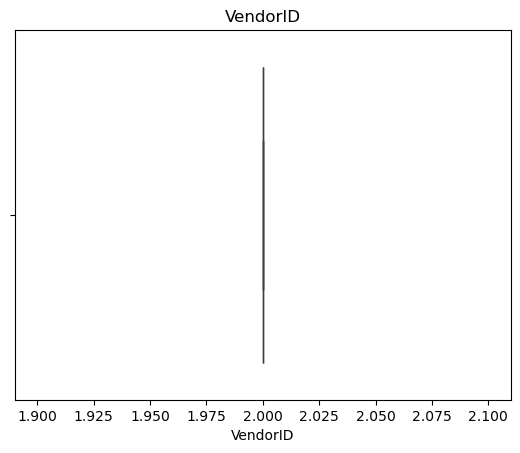

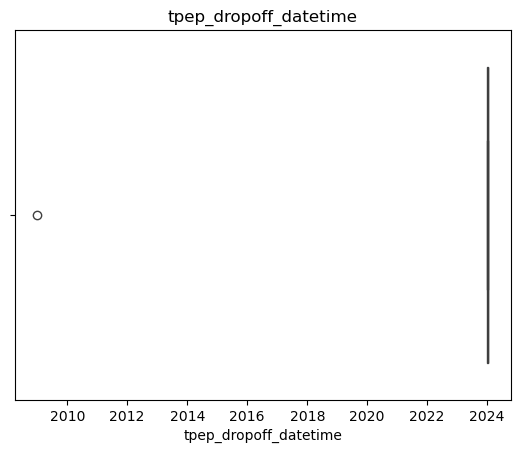

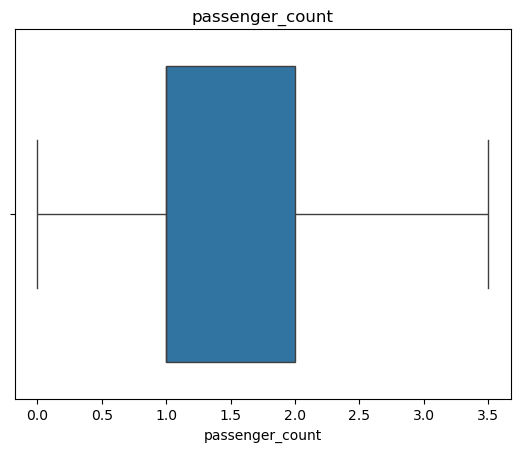

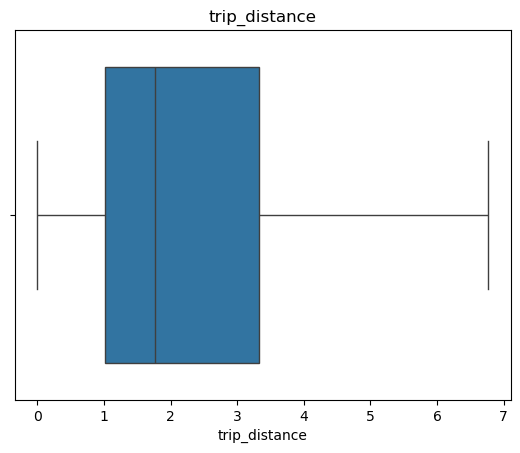

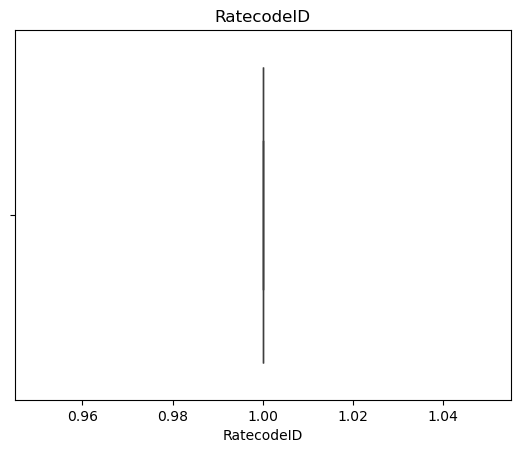

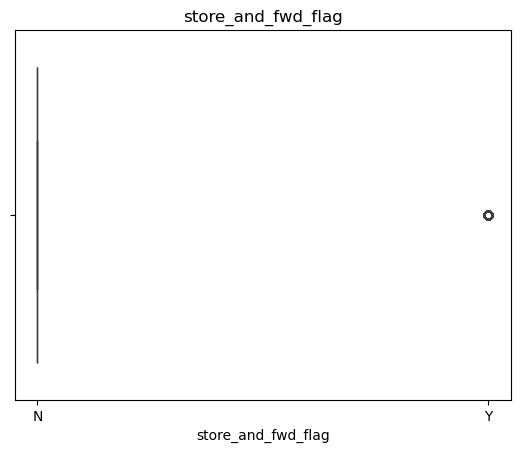

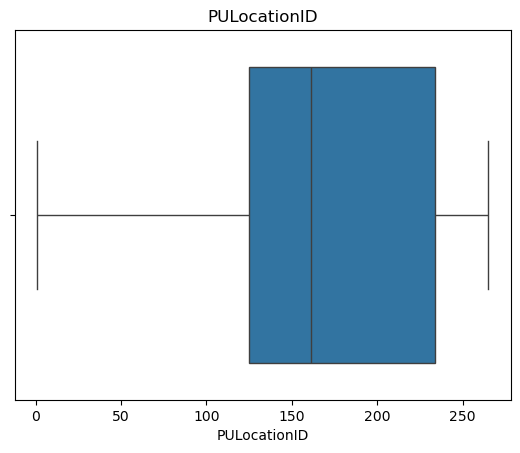

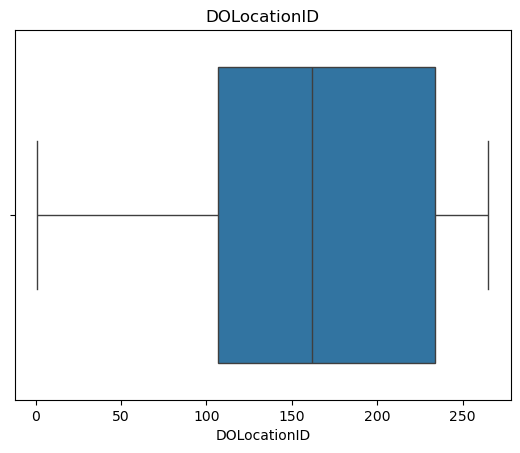

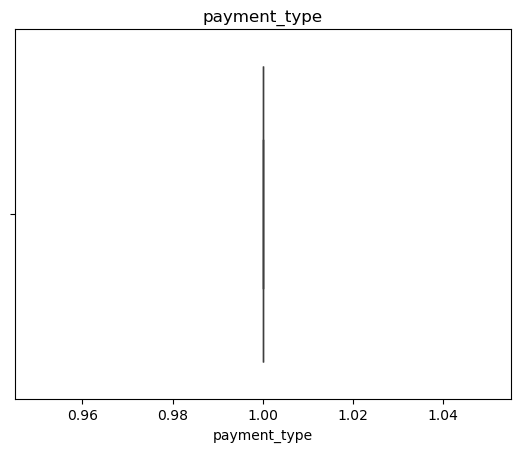

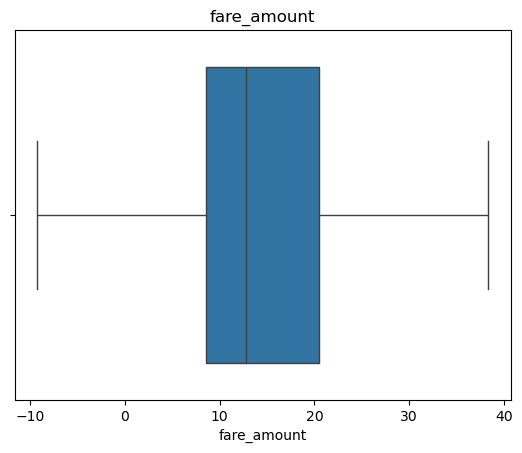

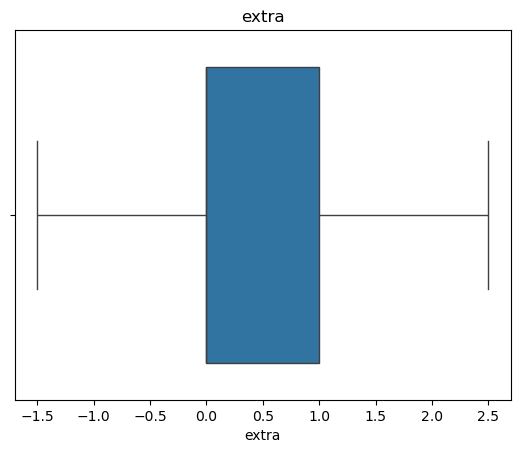

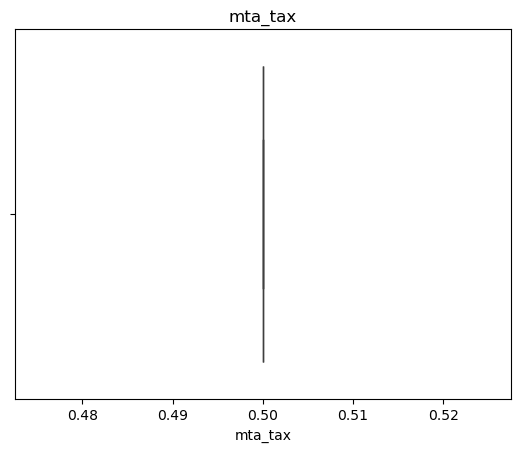

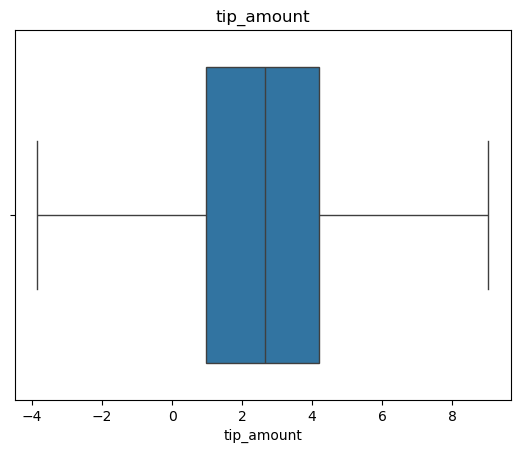

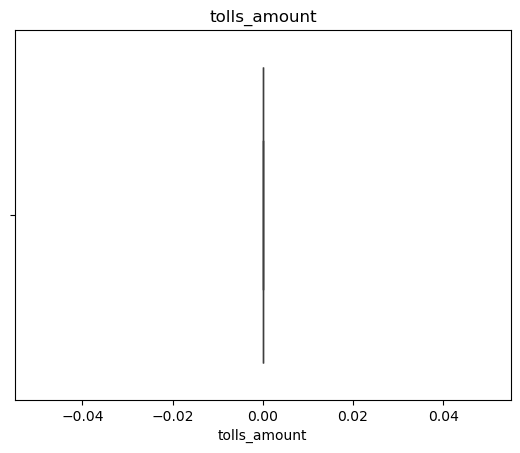

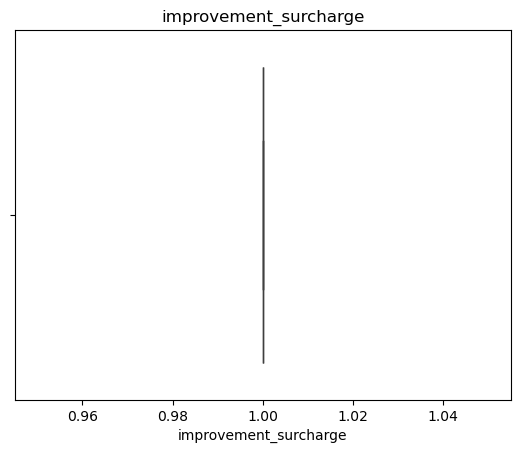

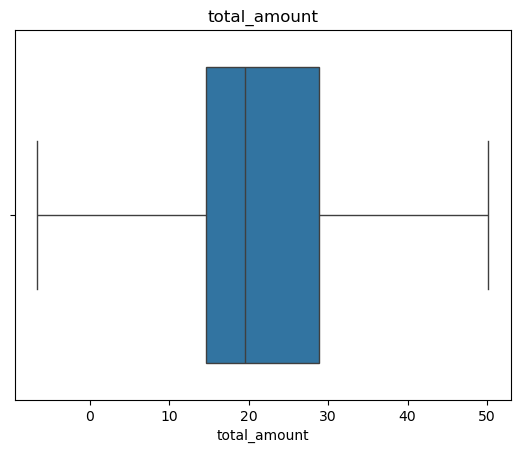

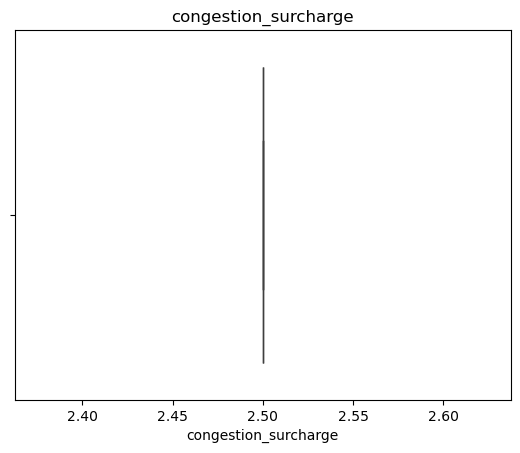

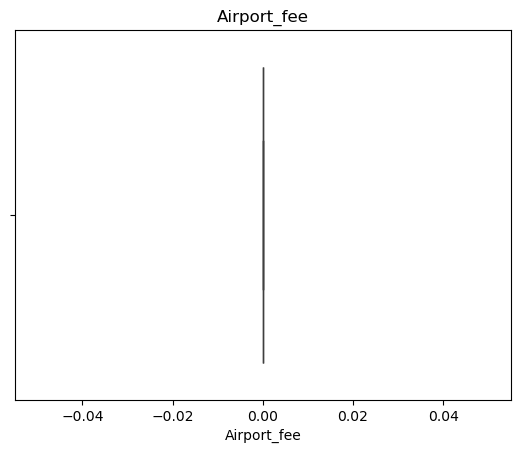

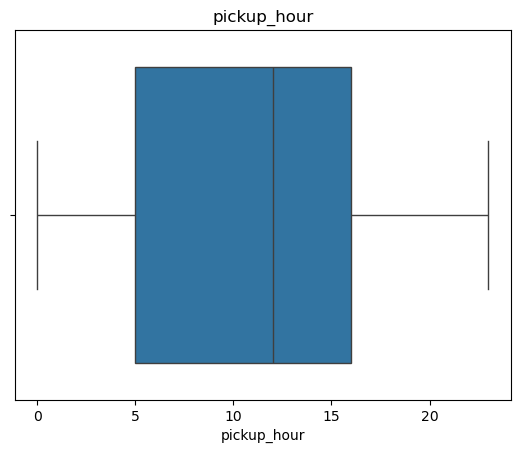

In [38]:
t = df.columns.values
def outliers(x):
    t = x.select_dtypes(include=[int,float])
    for i in x:
        sns.boxplot(x=df[i])
        plt.title(i)
        plt.show()
outliers(df) 

In [40]:
print(df.head())

                      VendorID tpep_dropoff_datetime  passenger_count  \
tpep_pickup_datetime                                                    
2024-01-13 03:18:09        2.0   2024-01-13 03:24:37              1.0   
2024-01-13 03:52:58        2.0   2024-01-13 04:01:18              1.0   
2024-01-13 03:26:02        2.0   2024-01-13 03:34:43              1.0   
2024-01-13 03:53:44        2.0   2024-01-13 04:10:56              1.0   
2024-01-13 02:58:28        2.0   2024-01-13 03:14:33              1.0   

                      trip_distance  RatecodeID store_and_fwd_flag  \
tpep_pickup_datetime                                                 
2024-01-13 03:18:09            2.31         1.0                  N   
2024-01-13 03:52:58            2.61         1.0                  N   
2024-01-13 03:26:02            1.79         1.0                  N   
2024-01-13 03:53:44            6.58         1.0                  N   
2024-01-13 02:58:28            3.40         1.0                  N  

In [42]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
df['pickup_datetime'] = pd.to_datetime(df.index)  # Convert the index to datetime
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
df['pickup_month'] = df['pickup_datetime'].dt.month

# Select relevant features and the target variable (fare_amount)
features = df[['trip_distance', 'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_month', 
                'VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type']]
target = df['fare_amount']


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 24.180447052273475


In [48]:
import joblib

# Save the model
joblib.dump(model, 'fare_prediction_model.pkl')


['fare_prediction_model.pkl']